## **1. Import Data**

In [1]:
# Supress warnings

import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, datetime, pytz, re, os, category_encoders as ce, xgboost, statsmodels.api as sm, joblib

#from sdv.tabular import CTGAN, CopulaGAN
from sklearn import (metrics, preprocessing, model_selection, feature_selection, linear_model, ensemble)
from sklearn.decomposition import PCA
from imblearn.over_sampling import (SMOTE, ADASYN)
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# load 10% data

low_df_10 = pd.read_excel('10_modelling_data.xlsx')
low_df_10.head()

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Response,Less_than_1_year,More_than_2_years,Region_Code_10,...,Region_Code_6,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26
0,1,22,0,1,2630,207,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,29,1,0,36203,200,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,21,1,0,27240,33,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,59,0,1,37559,154,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,1,24,1,0,23031,198,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Take copy of data

md_data_10 = low_df_10.copy()
md_data_10.head()

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Response,Less_than_1_year,More_than_2_years,Region_Code_10,...,Region_Code_6,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26
0,1,22,0,1,2630,207,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,29,1,0,36203,200,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,21,1,0,27240,33,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,59,0,1,37559,154,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,1,24,1,0,23031,198,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# continuous variables

cont_vars = ['Age', 'Annual_Premium', 'Vintage']

<AxesSubplot:>

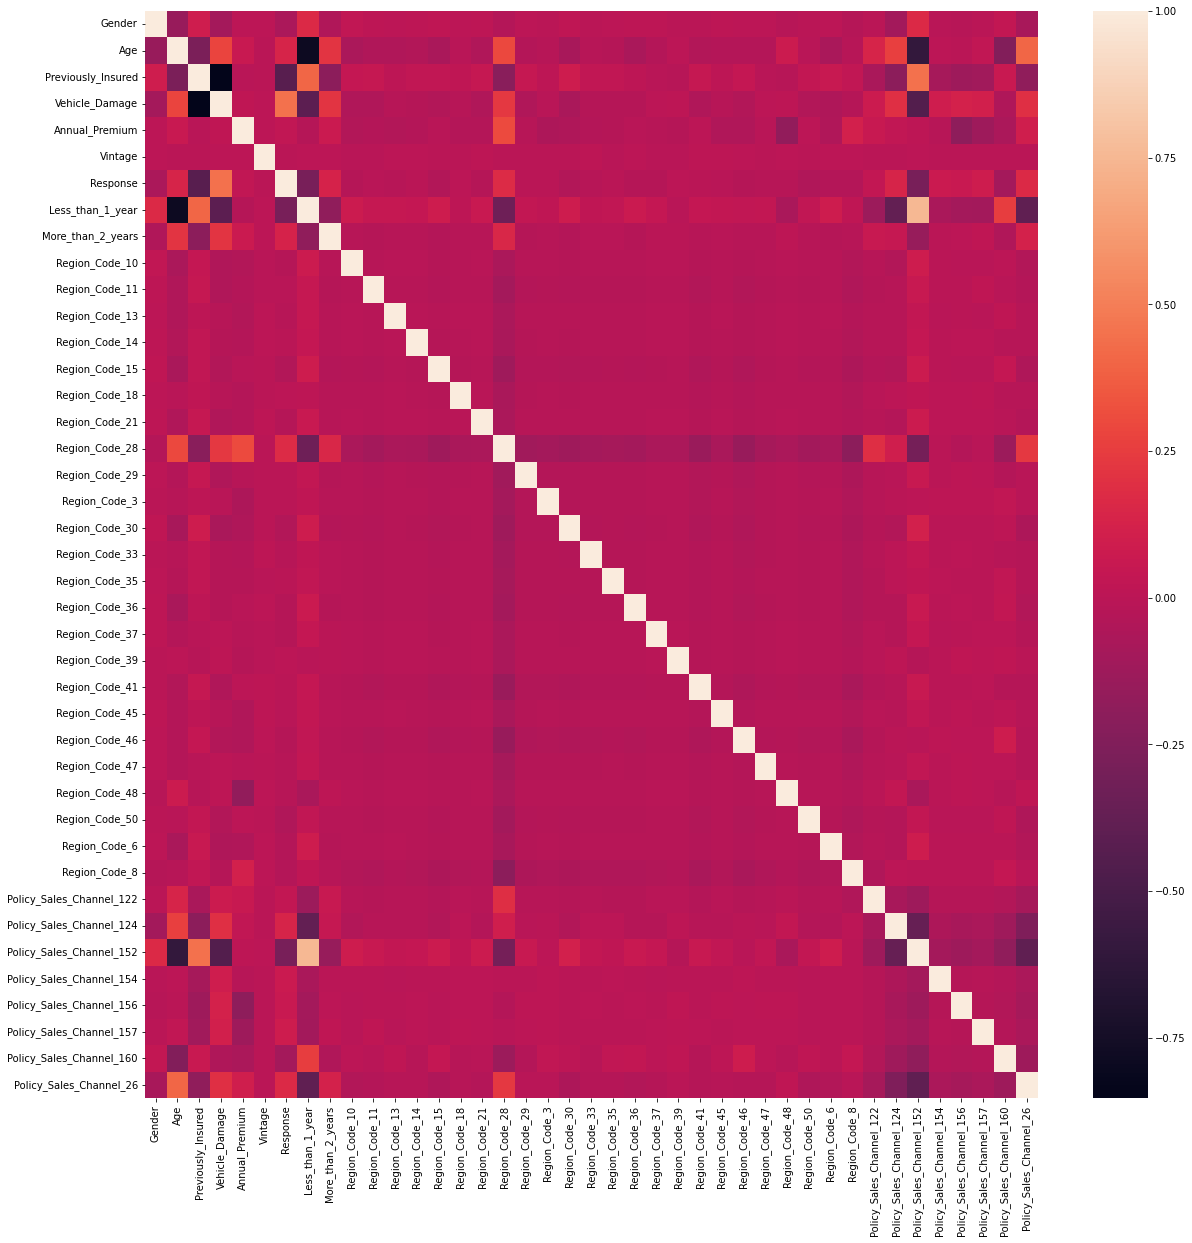

In [5]:
# correlation plot

plt.figure(figsize=(20,20))
sns.heatmap(md_data_10.corr())

In [6]:
# Reusable Functions

def normalize_train_test_split(df, cont_vars, return_balanced_data=False):
    
    y = df.pop('Response')
    
    lr_X_train, lr_X_val, lr_y_train, lr_y_val = model_selection.train_test_split(df, y, train_size=0.7, random_state=42, stratify=y)
    print(lr_X_train.shape, lr_X_val.shape)

    # normalize continuous variables

    scaler = preprocessing.StandardScaler()
    lr_X_train[cont_vars] = scaler.fit_transform(lr_X_train[cont_vars])
    lr_X_val[cont_vars] = scaler.transform(lr_X_val[cont_vars])
    
    # Balance the imbalance data
    
    if return_balanced_data:
        ada = ADASYN(random_state=42, n_jobs=-1)
        lr_X_train, lr_y_train = ada.fit_resample(lr_X_train, lr_y_train)
    print(lr_X_train.shape, lr_y_train.shape, lr_X_val.shape, lr_y_val.shape)
    return lr_X_train, lr_y_train, lr_X_val, lr_y_val

# Function for smote and adasyn oversampling

def smote_adasyn_synthetic_data(df_x, df_y):
    y = df_y
    
    sampling_strategy={0:(len(df_x)-sum(y))*2, 1:sum(y)*2}
    smote_obj = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    adasyn_obj = ADASYN(sampling_strategy=sampling_strategy, random_state=42)
    
    X_smote, y_smote = smote_obj.fit_resample(df_x, y)
    X_adasyn, y_adasyn = adasyn_obj.fit_resample(df_x, y)
    
    print(X_smote.shape, y_smote.shape, X_adasyn.shape, y_adasyn.shape, sum(y_smote), sum(y_adasyn))
    return X_smote, y_smote, X_adasyn, y_adasyn

def rfe_feature_selection(model_obj, train_df_X, train_df_y, col_num):

    rfe = feature_selection.RFE(estimator=model_obj, n_features_to_select=col_num)
    rfe = rfe.fit(train_df_X, train_df_y)

    col = list(train_df_X.columns[rfe.support_])
    print(len(col))
    return col

# functions to fit the model, calculate accuracy and vif

def run_statsmodel(df_X, df_y):
    X_train_rfe = sm.add_constant(df_X)
    lm = sm.GLM(df_y, X_train_rfe, family=sm.families.Binomial()).fit()
    return lm.summary(), lm

def calculate_accuracy(lm, var_list, df, labels, predict_proba=False):
    if predict_proba:
        lr_y_train_pred = lm.predict_proba(df)[:,1]
    else:
        lr_y_train_pred = lm.predict(sm.add_constant(df[var_list])).values.reshape(-1)
    df = pd.DataFrame()
    df['Converted'] = labels.values
    df['Conv_Prob'] = lr_y_train_pred
    df['Predicted'] = df['Conv_Prob'].apply(lambda x : 1 if x > 0.5 else 0)
    cm = metrics.confusion_matrix(df['Converted'], df['Predicted'])
    accuracy = metrics.accuracy_score(df['Converted'], df['Predicted'])
    return df, cm, round(accuracy, 3)

def calculate_VIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [round(variance_inflation_factor(df.values, i),2) for i in range(df.shape[1])]
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def calculate_accuracy_vif(trained_model, col_list, train_df, labels):
    y_train_pred, cm_matrix, model_accuracy = calculate_accuracy(trained_model, col_list, train_df, labels)
    print(f'Accuracy of Model is {model_accuracy}')
    VIF_df = calculate_VIF(train_df[col_list])
    print(cm_matrix)
    return y_train_pred, cm_matrix, VIF_df

def calculate_oprimal_threshold(fpr, tpr, thresholds):
    df_roc = pd.DataFrame()
    df_roc['thresholds'] = thresholds
    df_roc['tpr'] = tpr
    df_roc['fpr'] = fpr
    df_roc['spec'] = 1-fpr
    df_roc['diff'] = np.abs(df_roc['tpr']-df_roc['spec'])
    df_roc = df_roc.sort_values('diff')
    return df_roc 
    
def evaluate_model(df, pred, train=True):
    cm = metrics.confusion_matrix(df['Converted'], df[pred])
    TP = cm[1,1] # True Positive
    TN = cm[0,0] # True Negative
    FP = cm[0,1] # False Positive
    FN = cm[1,0] # False Negative
    acc = round(metrics.accuracy_score(df['Converted'], df[pred]), 3)
    rv = round(metrics.recall_score(df['Converted'], df[pred]), 3)
    pv = round(metrics.precision_score(df['Converted'], df[pred]), 3)
    f1 = round(metrics.f1_score(df['Converted'], df[pred]), 3)
    auc = round(metrics.roc_auc_score(df['Converted'], df['Conv_Prob']), 3)
    sv = round(TN / float(TN+FP), 3)
    g_mean = round(np.sqrt(rv*sv), 3)
    print_str = f'Accuracy: {acc}, Recall: {rv}, Precision: {pv}, F1-score: {f1}, AUC: {auc}, Specificity: {sv}, G-Mean: {g_mean}'
    if train:
        fpr, tpr, thresholds = metrics.roc_curve(df['Converted'], df['Conv_Prob'])
        df_roc = calculate_oprimal_threshold(fpr, tpr, thresholds)
        print(df_roc.head())
        opt_threshold = round(df_roc.iloc[0]['thresholds'], 2)
        print_str += f', Optimal Threshold: {opt_threshold}'
        print(print_str)
        return fpr, tpr, thresholds, opt_threshold
    else:
        print(print_str)
    
    
def calculate_labels_at_diff_thresholds(df):  
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df[i]= df['Conv_Prob'].map(lambda x: 1 if x > i else 0)

    cutoff_df = pd.DataFrame(columns = ['prob','accuracy','sensi','speci'])

    for i in numbers:
        cm1 = metrics.confusion_matrix(df['Converted'], df[i])
        accuracy = metrics.accuracy_score(df['Converted'], df[i])
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[int(i*10)] =[i ,accuracy,sensi,speci]
    return cutoff_df

def evaluate_model_on_test_data(mdl_obj, val_x, cols_list, val_y, threshold_val, predict_proba=False):
    if predict_proba:
        y_test_pred = mdl_obj.predict_proba(val_x)[:,1]
    else:
        y_test_pred = mdl_obj.predict(sm.add_constant(val_x[cols_list]))
    y_test_pred_final = pd.DataFrame()
    y_test_pred_final['Converted'] = val_y
    y_test_pred_final['Conv_Prob'] = y_test_pred
    y_test_pred_final['final_predicted'] = y_test_pred_final.Conv_Prob.map(lambda x: 1 if x > threshold_val else 0)
    evaluate_model(y_test_pred_final, pred='final_predicted', train=False)

In [7]:
# Split the data

lr_X_train_10, lr_y_train_10, lr_X_val_10, lr_y_val_10 = normalize_train_test_split(md_data_10, cont_vars, return_balanced_data=False)

(26750, 40) (11465, 40)
(26750, 40) (26750,) (11465, 40) (11465,)


In [8]:
%%time
# Enhance data with Synthetic data

X_train_low_10_smote, y_train_low_10_smote, X_train_low_10_adasyn, y_train_low_10_adasyn = smote_adasyn_synthetic_data(lr_X_train_10, lr_y_train_10)

(53500, 40) (53500,) (53694, 40) (53694,) 8764 8665
Wall time: 1min 1s


In [9]:
# Train data

lr_X_train_10_gan = lr_X_train_10.copy()
lr_X_train_10_gan['Response'] = lr_y_train_10.copy()
lr_X_train_10_gan

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Less_than_1_year,More_than_2_years,Region_Code_10,Region_Code_11,...,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26,Response
13616,0,2.523170,1,0,2.119853,1.503789,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3142,1,-0.894231,1,0,-1.659646,-1.483532,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23933,0,-0.894231,1,0,0.348278,-0.412381,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23216,0,0.354434,0,1,0.480968,-0.674218,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
34521,0,1.077346,0,1,-1.659646,-1.435925,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25615,1,1.603100,1,0,0.449215,0.920607,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
19815,1,1.471662,1,0,0.039080,0.515950,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30903,1,2.588889,1,0,0.497939,1.313363,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7476,1,-0.565635,1,0,0.302392,-0.543299,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [10]:
# load synthetic data generated by GAN

gan_data_10 = pd.read_excel('20220818061858641143cp_syn_data_10_train.xlsx')[lr_X_train_10_gan.columns]
gan_data_10

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Less_than_1_year,More_than_2_years,Region_Code_10,Region_Code_11,...,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26,Response
0,1,59,0,1,44971,157,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,63,1,0,24079,118,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,23,0,0,21259,86,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,1,49,1,0,49709,65,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,41,0,1,2630,89,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26745,1,23,1,0,36170,256,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
26746,1,22,1,0,28780,153,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
26747,1,25,0,1,37542,53,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
26748,0,70,1,0,2630,37,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
# Balance the train data

scaler = preprocessing.StandardScaler()
gan_data_10[cont_vars] = scaler.fit_transform(gan_data_10[cont_vars])
X_train_low_10_gan = pd.concat([lr_X_train_10_gan, gan_data_10])
X_train_low_10_gan

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Less_than_1_year,More_than_2_years,Region_Code_10,Region_Code_11,...,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26,Response
13616,0,2.523170,1,0,2.119853,1.503789,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3142,1,-0.894231,1,0,-1.659646,-1.483532,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23933,0,-0.894231,1,0,0.348278,-0.412381,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23216,0,0.354434,0,1,0.480968,-0.674218,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
34521,0,1.077346,0,1,-1.659646,-1.435925,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26745,1,-1.001715,1,0,0.195758,1.123634,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
26746,1,-1.062832,1,0,-0.235952,-0.094102,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
26747,1,-0.879482,0,1,0.275908,-1.276369,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
26748,0,1.870756,1,0,-1.763586,-1.465532,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
# prepare X_train and y_train

y_train_low_10_gan = X_train_low_10_gan.pop('Response')
X_train_low_10_gan = X_train_low_10_gan

## **2. Logistic Regression**
### **2.1 Original Data**

In [13]:
# Automated feature selection

logreg_rfe_base = linear_model.LogisticRegression()
logreg_rfe_base.fit(lr_X_train_10, lr_y_train_10)
col_base = rfe_feature_selection(logreg_rfe_base, lr_X_train_10, lr_y_train_10, 15)

15


In [14]:
# Fit model with 15 cols

col_1_base = col_base.copy()
mod_1_base, lm_1_base = run_statsmodel(lr_X_train_10[col_1_base], lr_y_train_10)
mod_1_base

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:                26750
Model:                            GLM   Df Residuals:                    26734
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7606.9
Date:                Thu, 18 Aug 2022   Deviance:                       15214.
Time:                        13:39:37   Pearson chi2:                 3.10e+04
No. Iterations:                    11   Pseudo R-squ. (CS):             0.2761
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.8385      0.149    -19.064      0.000      -3.130      -2.547
Age                         -0.5313      0.030    -17.716      0.000      -0.590      -0.473
Previously_Insured          -4.4444      0.387    -11.495      0.000      -5.202      -3.687
Vehicle_Damage               2.5864      0.148     17.467      0.000       2.296       2.877
Less_than_1_year            -0.6928      0.084     -8.215      0.000      -0.858      -0.527
Region_Code_11               0.5187      0.145      3.568      0.000       0.234       0.804
Region_Code_14               0.5238      0.197      2.661      0.008       0.138       0.910
Region_Code_18               0.3377      0.163      2.071      0.038       0.018       0.657
Region_Code_29               0.3690      0.121      3.045      0.002       0.132       0.607
Region_Code_35               0.4367      0.155      2.822      0.005       0.133       0.740
Region_Code_41               0.4286      0.097      4.422      0.000       0.239       0.619
Region_Code_48              -0.7528      0.195     -3.869      0.000      -1.134      -0.371
Region_Code_50              -0.9090      0.189     -4.810      0.000      -1.279      -0.539
Policy_Sales_Channel_152    -1.4384      0.098    -14.615      0.000      -1.631      -1.245
Policy_Sales_Channel_160    -2.4399      0.210    -11.592      0.000      -2.852      -2.027
Policy_Sales_Channel_26      0.3774      0.044      8.665      0.000       0.292       0.463
============================================================================================
"""

In [15]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_1_base, lr_cm_1_base, lr_VIF_1_base = calculate_accuracy_vif(lm_1_base, col_1_base, lr_X_train_10, lr_y_train_10)
lr_VIF_1_base

Accuracy of Model is 0.837
[[21579   789]
 [ 3579   803]]


,Features,VIF
3,Less_than_1_year,8.19
12,Policy_Sales_Channel_152,5.96
1,Previously_Insured,2.97
0,Age,2.61
2,Vehicle_Damage,1.82
13,Policy_Sales_Channel_160,1.75
14,Policy_Sales_Channel_26,1.56
9,Region_Code_41,1.06
7,Region_Code_29,1.04
11,Region_Code_50,1.04


In [16]:
# fit the model with out 'Less_than_1_year' as is has high vif value

col_1_base.remove('Less_than_1_year')

col_2_base = col_1_base.copy()
mod_2_base, lm_2_base = run_statsmodel(lr_X_train_10[col_2_base], lr_y_train_10)
mod_2_base

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:                26750
Model:                            GLM   Df Residuals:                    26735
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7641.1
Date:                Thu, 18 Aug 2022   Deviance:                       15282.
Time:                        13:39:39   Pearson chi2:                 3.05e+04
No. Iterations:                    11   Pseudo R-squ. (CS):             0.2743
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.9541      0.148    -19.924      0.000      -3.245      -2.663
Age                         -0.4227      0.026    -15.954      0.000      -0.475      -0.371
Previously_Insured          -4.4600      0.387    -11.536      0.000      -5.218      -3.702
Vehicle_Damage               2.6030      0.148     17.594      0.000       2.313       2.893
Region_Code_11               0.5245      0.145      3.619      0.000       0.240       0.808
Region_Code_14               0.5237      0.196      2.674      0.007       0.140       0.908
Region_Code_18               0.3185      0.163      1.959      0.050      -0.000       0.637
Region_Code_29               0.3866      0.121      3.201      0.001       0.150       0.623
Region_Code_35               0.4289      0.154      2.777      0.005       0.126       0.732
Region_Code_41               0.4198      0.097      4.340      0.000       0.230       0.609
Region_Code_48              -0.7240      0.194     -3.737      0.000      -1.104      -0.344
Region_Code_50              -0.9151      0.189     -4.851      0.000      -1.285      -0.545
Policy_Sales_Channel_152    -1.8855      0.083    -22.801      0.000      -2.048      -1.723
Policy_Sales_Channel_160    -2.8854      0.204    -14.171      0.000      -3.284      -2.486
Policy_Sales_Channel_26      0.3677      0.043      8.474      0.000       0.283       0.453
============================================================================================
"""

In [17]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_2_base, lr_cm_2_base, lr_VIF_2_base = calculate_accuracy_vif(lm_2_base, col_2_base, lr_X_train_10, lr_y_train_10)
lr_VIF_2_base

Accuracy of Model is 0.831
[[21594   774]
 [ 3757   625]]


,Features,VIF
11,Policy_Sales_Channel_152,3.36
1,Previously_Insured,2.70
0,Age,1.97
2,Vehicle_Damage,1.64
13,Policy_Sales_Channel_26,1.55
12,Policy_Sales_Channel_160,1.37
8,Region_Code_41,1.06
6,Region_Code_29,1.04
10,Region_Code_50,1.04
3,Region_Code_11,1.03


In [18]:
# fit the model with out 'Region_Code_18' as is has high p-value

col_2_base.remove('Region_Code_18')

col_3_base = col_2_base.copy()
mod_3_base, lm_3_base = run_statsmodel(lr_X_train_10[col_3_base], lr_y_train_10)
mod_3_base

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:                26750
Model:                            GLM   Df Residuals:                    26736
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7643.0
Date:                Thu, 18 Aug 2022   Deviance:                       15286.
Time:                        13:39:40   Pearson chi2:                 3.04e+04
No. Iterations:                    11   Pseudo R-squ. (CS):             0.2742
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.9464      0.148    -19.882      0.000      -3.237      -2.656
Age                         -0.4236      0.026    -15.991      0.000      -0.475      -0.372
Previously_Insured          -4.4600      0.387    -11.537      0.000      -5.218      -3.702
Vehicle_Damage               2.6019      0.148     17.588      0.000       2.312       2.892
Region_Code_11               0.5190      0.145      3.582      0.000       0.235       0.803
Region_Code_14               0.5183      0.196      2.646      0.008       0.134       0.902
Region_Code_29               0.3813      0.121      3.158      0.002       0.145       0.618
Region_Code_35               0.4235      0.154      2.743      0.006       0.121       0.726
Region_Code_41               0.4143      0.097      4.286      0.000       0.225       0.604
Region_Code_48              -0.7294      0.194     -3.765      0.000      -1.109      -0.350
Region_Code_50              -0.9206      0.189     -4.880      0.000      -1.290      -0.551
Policy_Sales_Channel_152    -1.8889      0.083    -22.848      0.000      -2.051      -1.727
Policy_Sales_Channel_160    -2.8915      0.204    -14.203      0.000      -3.291      -2.493
Policy_Sales_Channel_26      0.3655      0.043      8.429      0.000       0.281       0.451
============================================================================================
"""

In [19]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_3_base, lr_cm_3_base, lr_VIF_3_base = calculate_accuracy_vif(lm_3_base, col_3_base, lr_X_train_10, lr_y_train_10)
lr_VIF_3_base

Accuracy of Model is 0.83
[[21593   775]
 [ 3773   609]]


,Features,VIF
10,Policy_Sales_Channel_152,3.36
1,Previously_Insured,2.69
0,Age,1.97
2,Vehicle_Damage,1.64
12,Policy_Sales_Channel_26,1.55
11,Policy_Sales_Channel_160,1.37
7,Region_Code_41,1.06
5,Region_Code_29,1.04
9,Region_Code_50,1.04
3,Region_Code_11,1.03


In [20]:
# Training predictions and Confusion matrix

train_pred_model = lm_3_base
train_cols = col_3_base
train_pred_df = lr_y_train_pred_final_3_base
train_pred_cm = lr_cm_3_base

In [21]:
# Evaluate model

fpr, tpr, thresholds, opt_threshold = evaluate_model(train_pred_df, pred='Predicted')

     thresholds       tpr       fpr      spec      diff
399    0.340483  0.810132  0.186472  0.813528  0.003396
398    0.341201  0.810132  0.186427  0.813573  0.003441
397    0.341722  0.806937  0.185175  0.814825  0.007887
396    0.344419  0.806937  0.185131  0.814869  0.007932
395    0.344751  0.806709  0.185131  0.814869  0.008160
Accuracy: 0.83, Recall: 0.139, Precision: 0.44, F1-score: 0.211, AUC: 0.88, Specificity: 0.965, G-Mean: 0.366, Optimal Threshold: 0.34


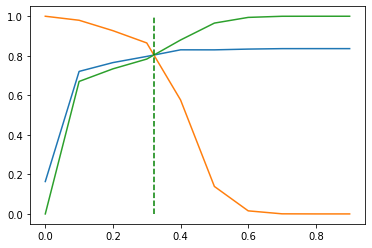

In [22]:
# Plot Accuracy, Recall and Spesificity at diff thresholds

cutoff_df = calculate_labels_at_diff_thresholds(train_pred_df)
plt.plot(cutoff_df['prob'], cutoff_df['accuracy'])
plt.plot(cutoff_df['prob'], cutoff_df['sensi'])
plt.plot(cutoff_df['prob'], cutoff_df['speci'])
plt.vlines(x=.32, ymax=1, ymin=0, colors='g', linestyles='--')

In [23]:
# Calculate labels at optimal threshold and recalculate metrics

train_pred_df['final_predicted'] = train_pred_df.Conv_Prob.map( lambda x: 1 if x > opt_threshold else 0)
evaluate_model(train_pred_df, pred='final_predicted')
train_pred_df.head()

     thresholds       tpr       fpr      spec      diff
399    0.340483  0.810132  0.186472  0.813528  0.003396
398    0.341201  0.810132  0.186427  0.813573  0.003441
397    0.341722  0.806937  0.185175  0.814825  0.007887
396    0.344419  0.806937  0.185131  0.814869  0.007932
395    0.344751  0.806709  0.185131  0.814869  0.008160
Accuracy: 0.811, Recall: 0.819, Precision: 0.458, F1-score: 0.587, AUC: 0.88, Specificity: 0.81, G-Mean: 0.814, Optimal Threshold: 0.34


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.000209,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.000134,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.000134,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.378813,0,1,1,1,1,0,0,0,0,0,0,1
4,1,0.392872,0,1,1,1,1,0,0,0,0,0,0,1


In [24]:
# Evaluate model on test data

evaluate_model_on_test_data(train_pred_model, lr_X_val_10, train_cols, lr_y_val_10, opt_threshold)

Accuracy: 0.811, Recall: 0.822, Precision: 0.457, F1-score: 0.587, AUC: 0.879, Specificity: 0.808, G-Mean: 0.815


## **2.2 SMOTE Data**

In [25]:
# Automated feature selection

logreg_rfe_smote = linear_model.LogisticRegression()
logreg_rfe_smote.fit(X_train_low_10_smote, y_train_low_10_smote)
col_smote = rfe_feature_selection(logreg_rfe_smote, X_train_low_10_smote, y_train_low_10_smote, 15)

15


In [26]:
# Fit model with 15 cols

col_1_smote = col_smote.copy()
mod_1_smote, lm_1_smote = run_statsmodel(X_train_low_10_smote[col_1_smote], y_train_low_10_smote)
mod_1_smote

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:                53500
Model:                            GLM   Df Residuals:                    53484
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15143.
Date:                Thu, 18 Aug 2022   Deviance:                       30286.
Time:                        13:40:00   Pearson chi2:                 5.83e+04
No. Iterations:                    11   Pseudo R-squ. (CS):             0.2780
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.7468      0.102    -26.963      0.000      -2.946      -2.547
Age                         -0.5645      0.022    -25.761      0.000      -0.607      -0.522
Previously_Insured          -4.9960      0.384    -13.024      0.000      -5.748      -4.244
Vehicle_Damage               2.5285      0.102     24.907      0.000       2.330       2.727
Less_than_1_year            -0.7924      0.063    -12.672      0.000      -0.915      -0.670
Region_Code_11               0.4914      0.118      4.152      0.000       0.259       0.723
Region_Code_14               0.7334      0.168      4.372      0.000       0.405       1.062
Region_Code_18               0.5145      0.132      3.892      0.000       0.255       0.774
Region_Code_29               0.3768      0.092      4.079      0.000       0.196       0.558
Region_Code_41               0.4447      0.072      6.136      0.000       0.303       0.587
Region_Code_47              -0.5144      0.132     -3.886      0.000      -0.774      -0.255
Region_Code_48              -0.9756      0.154     -6.319      0.000      -1.278      -0.673
Region_Code_50              -1.1682      0.158     -7.412      0.000      -1.477      -0.859
Policy_Sales_Channel_152    -1.4809      0.073    -20.180      0.000      -1.625      -1.337
Policy_Sales_Channel_160    -2.5609      0.160    -15.985      0.000      -2.875      -2.247
Policy_Sales_Channel_26      0.3748      0.031     12.168      0.000       0.314       0.435
============================================================================================
"""

In [27]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_1_smote, lr_cm_1_smote, lr_VIF_1_smote = calculate_accuracy_vif(lm_1_smote, col_1_smote, X_train_low_10_smote, y_train_low_10_smote)
lr_VIF_1_smote

Accuracy of Model is 0.838
[[43242  1494]
 [ 7178  1586]]


,Features,VIF
3,Less_than_1_year,8.63
12,Policy_Sales_Channel_152,6.25
1,Previously_Insured,3.02
0,Age,2.71
2,Vehicle_Damage,1.83
13,Policy_Sales_Channel_160,1.80
14,Policy_Sales_Channel_26,1.57
8,Region_Code_41,1.06
7,Region_Code_29,1.04
4,Region_Code_11,1.03


In [28]:
# fit the model with out 'Less_than_1_year' as is has high vif value

col_1_smote.remove('Less_than_1_year')

col_2_smote = col_1_smote.copy()
mod_2_smote, lm_2_smote = run_statsmodel(X_train_low_10_smote[col_2_smote], y_train_low_10_smote)
mod_2_smote

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:                53500
Model:                            GLM   Df Residuals:                    53485
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15225.
Date:                Thu, 18 Aug 2022   Deviance:                       30450.
Time:                        13:40:02   Pearson chi2:                 5.75e+04
No. Iterations:                    11   Pseudo R-squ. (CS):             0.2758
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.8745      0.101    -28.340      0.000      -3.073      -2.676
Age                         -0.4428      0.019    -22.898      0.000      -0.481      -0.405
Previously_Insured          -5.0110      0.384    -13.064      0.000      -5.763      -4.259
Vehicle_Damage               2.5494      0.101     25.132      0.000       2.351       2.748
Region_Code_11               0.4986      0.118      4.220      0.000       0.267       0.730
Region_Code_14               0.7339      0.167      4.406      0.000       0.407       1.060
Region_Code_18               0.5010      0.132      3.805      0.000       0.243       0.759
Region_Code_29               0.3993      0.092      4.339      0.000       0.219       0.580
Region_Code_41               0.4411      0.072      6.109      0.000       0.300       0.583
Region_Code_47              -0.5585      0.133     -4.205      0.000      -0.819      -0.298
Region_Code_48              -0.9467      0.154     -6.155      0.000      -1.248      -0.645
Region_Code_50              -1.1818      0.157     -7.513      0.000      -1.490      -0.874
Policy_Sales_Channel_152    -2.0058      0.061    -32.881      0.000      -2.125      -1.886
Policy_Sales_Channel_160    -3.0831      0.155    -19.903      0.000      -3.387      -2.779
Policy_Sales_Channel_26      0.3646      0.031     11.891      0.000       0.305       0.425
============================================================================================
"""

In [29]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_2_smote, lr_cm_2_smote, lr_VIF_2_smote = calculate_accuracy_vif(lm_2_smote, col_2_smote, X_train_low_10_smote, y_train_low_10_smote)
lr_VIF_2_smote

Accuracy of Model is 0.83
[[43218  1518]
 [ 7585  1179]]


,Features,VIF
11,Policy_Sales_Channel_152,3.49
1,Previously_Insured,2.73
0,Age,2.06
2,Vehicle_Damage,1.65
13,Policy_Sales_Channel_26,1.55
12,Policy_Sales_Channel_160,1.39
7,Region_Code_41,1.06
6,Region_Code_29,1.04
3,Region_Code_11,1.03
10,Region_Code_50,1.03


In [30]:
# Training predictions and Confusion matrix

train_pred_model_smote = lm_2_smote
train_cols_smote = col_2_smote
train_pred_df_smote = lr_y_train_pred_final_2_smote
train_pred_cm_smote = lr_cm_2_smote

In [31]:
# Evaluate model

fpr_smote, tpr_smote, thresholds_smote, opt_threshold_smote = evaluate_model(train_pred_df_smote, pred='Predicted')

      thresholds       tpr       fpr      spec          diff
4006    0.343647  0.812186  0.187813  0.812187  8.365932e-07
4007    0.343628  0.812186  0.187835  0.812165  2.151677e-05
4005    0.343663  0.812072  0.187813  0.812187  1.149397e-04
4004    0.343684  0.812072  0.187791  0.812209  1.372931e-04
4003    0.343695  0.811958  0.187791  0.812209  2.513963e-04
Accuracy: 0.83, Recall: 0.135, Precision: 0.437, F1-score: 0.206, AUC: 0.881, Specificity: 0.966, G-Mean: 0.361, Optimal Threshold: 0.34


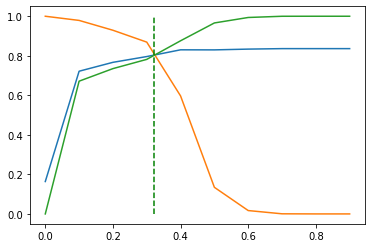

In [32]:
# Plot Accuracy, Recall and Spesificity at diff thresholds

cutoff_df_smote = calculate_labels_at_diff_thresholds(train_pred_df_smote)
plt.plot(cutoff_df_smote['prob'], cutoff_df_smote['accuracy'])
plt.plot(cutoff_df_smote['prob'], cutoff_df_smote['sensi'])
plt.plot(cutoff_df_smote['prob'], cutoff_df_smote['speci'])
plt.vlines(x=.32, ymax=1, ymin=0, colors='g', linestyles='--')

In [33]:
# Calculate labels at optimal threshold and recalculate metrics

train_pred_df_smote['final_predicted'] = train_pred_df_smote.Conv_Prob.map( lambda x: 1 if x > opt_threshold_smote else 0)
evaluate_model(train_pred_df_smote, pred='final_predicted')
train_pred_df_smote.head()

      thresholds       tpr       fpr      spec          diff
4006    0.343647  0.812186  0.187813  0.812187  8.365932e-07
4007    0.343628  0.812186  0.187835  0.812165  2.151677e-05
4005    0.343663  0.812072  0.187813  0.812187  1.149397e-04
4004    0.343684  0.812072  0.187791  0.812209  1.372931e-04
4003    0.343695  0.811958  0.187791  0.812209  2.513963e-04
Accuracy: 0.811, Recall: 0.82, Precision: 0.457, F1-score: 0.587, AUC: 0.881, Specificity: 0.809, G-Mean: 0.814, Optimal Threshold: 0.34


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.000123,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.000075,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.000075,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.381765,0,1,1,1,1,0,0,0,0,0,0,1
4,1,0.392331,0,1,1,1,1,0,0,0,0,0,0,1


In [34]:
# Evaluate model on test data

evaluate_model_on_test_data(train_pred_model_smote, lr_X_val_10, train_cols_smote, lr_y_val_10, opt_threshold_smote)

Accuracy: 0.812, Recall: 0.814, Precision: 0.459, F1-score: 0.587, AUC: 0.879, Specificity: 0.812, G-Mean: 0.813


### 2.3 **ADASYN data**


In [35]:
# Automated feature selection

logreg_rfe_ada = linear_model.LogisticRegression()
logreg_rfe_ada.fit(X_train_low_10_adasyn, y_train_low_10_adasyn)
col_ada = rfe_feature_selection(logreg_rfe_ada, X_train_low_10_adasyn, y_train_low_10_adasyn, 15)

15


In [36]:
# Fit model with 15 cols

col_1_ada = col_ada.copy()
mod_1_ada, lm_1_ada = run_statsmodel(X_train_low_10_adasyn[col_1_ada], y_train_low_10_adasyn)
mod_1_ada

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:                53694
Model:                            GLM   Df Residuals:                    53678
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20460.
Date:                Thu, 18 Aug 2022   Deviance:                       40920.
Time:                        13:40:25   Pearson chi2:                 4.91e+04
No. Iterations:                    10   Pseudo R-squ. (CS):             0.1147
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.9206      0.093    -31.539      0.000      -3.102      -2.739
Previously_Insured          -4.6626      0.384    -12.134      0.000      -5.416      -3.909
Vehicle_Damage               1.7157      0.093     18.487      0.000       1.534       1.898
Region_Code_11               0.5557      0.102      5.430      0.000       0.355       0.756
Region_Code_14               0.9726      0.154      6.299      0.000       0.670       1.275
Region_Code_18               0.3760      0.118      3.175      0.001       0.144       0.608
Region_Code_29               0.4323      0.081      5.340      0.000       0.274       0.591
Region_Code_3                0.4384      0.096      4.553      0.000       0.250       0.627
Region_Code_30               0.4047      0.104      3.895      0.000       0.201       0.608
Region_Code_35               0.4831      0.114      4.246      0.000       0.260       0.706
Region_Code_41               0.2900      0.062      4.702      0.000       0.169       0.411
Region_Code_47              -0.2422      0.122     -1.990      0.047      -0.481      -0.004
Region_Code_48              -0.5882      0.140     -4.204      0.000      -0.862      -0.314
Region_Code_50              -0.6800      0.150     -4.530      0.000      -0.974      -0.386
Policy_Sales_Channel_152    -0.5619      0.049    -11.396      0.000      -0.659      -0.465
Policy_Sales_Channel_160    -1.2900      0.136     -9.459      0.000      -1.557      -1.023
============================================================================================
"""

In [37]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_1_ada, lr_cm_1_ada, lr_VIF_1_ada = calculate_accuracy_vif(lm_1_ada, col_1_ada, X_train_low_10_adasyn, y_train_low_10_adasyn)
lr_VIF_1_ada

Accuracy of Model is 0.839
[[45029     0]
 [ 8665     0]]


,Features,VIF
0,Previously_Insured,1.81
13,Policy_Sales_Channel_152,1.74
1,Vehicle_Damage,1.14
14,Policy_Sales_Channel_160,1.08
9,Region_Code_41,1.06
7,Region_Code_30,1.05
2,Region_Code_11,1.03
5,Region_Code_29,1.03
12,Region_Code_50,1.03
3,Region_Code_14,1.02


In [38]:
# Training predictions and Confusion matrix

train_pred_model_ada = lm_1_ada
train_cols_ada = col_1_ada
train_pred_df_ada = lr_y_train_pred_final_1_ada
train_pred_cm_ada = lr_cm_1_ada

In [39]:
# Evaluate model

fpr_ada, tpr_ada, thresholds_ada, opt_threshold_ada = evaluate_model(train_pred_df_ada, pred='Predicted')

    thresholds       tpr       fpr      spec      diff
10    0.230614  0.901327  0.548691  0.451309  0.450018
11    0.229508  0.902827  0.549579  0.450421  0.452407
12    0.216919  0.903866  0.550157  0.449843  0.454023
13    0.209434  0.905020  0.551134  0.448866  0.456154
14    0.208416  0.905943  0.552000  0.448000  0.457943
Accuracy: 0.839, Recall: 0.0, Precision: 0.0, F1-score: 0.0, AUC: 0.705, Specificity: 1.0, G-Mean: 0.0, Optimal Threshold: 0.23


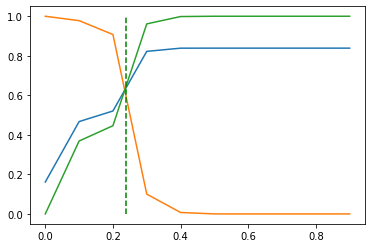

In [40]:
# Plot Accuracy, Recall and Spesificity at diff thresholds

cutoff_df_ada = calculate_labels_at_diff_thresholds(train_pred_df_ada)
plt.plot(cutoff_df_ada['prob'], cutoff_df_ada['accuracy'])
plt.plot(cutoff_df_ada['prob'], cutoff_df_ada['sensi'])
plt.plot(cutoff_df_ada['prob'], cutoff_df_ada['speci'])
plt.vlines(x=.24, ymax=1, ymin=0, colors='g', linestyles='--')

In [41]:
# Calculate labels at optimal threshold and recalculate metrics

train_pred_df_ada['final_predicted'] = train_pred_df_ada.Conv_Prob.map( lambda x: 1 if x > opt_threshold_ada else 0)
evaluate_model(train_pred_df_ada, pred='final_predicted')
train_pred_df_ada.head()

    thresholds       tpr       fpr      spec      diff
10    0.230614  0.901327  0.548691  0.451309  0.450018
11    0.229508  0.902827  0.549579  0.450421  0.452407
12    0.216919  0.903866  0.550157  0.449843  0.454023
13    0.209434  0.905020  0.551134  0.448866  0.456154
14    0.208416  0.905943  0.552000  0.448000  0.457943
Accuracy: 0.524, Recall: 0.901, Precision: 0.24, F1-score: 0.379, AUC: 0.705, Specificity: 0.451, G-Mean: 0.637, Optimal Threshold: 0.23


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.000509,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.000290,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.000290,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.230614,0,1,1,1,0,0,0,0,0,0,0,1
4,1,0.230614,0,1,1,1,0,0,0,0,0,0,0,1


In [42]:
# Evaluate model on test data

evaluate_model_on_test_data(train_pred_model_ada, lr_X_val_10, train_cols_ada, lr_y_val_10, opt_threshold_ada)

Accuracy: 0.769, Recall: 0.908, Precision: 0.408, F1-score: 0.563, AUC: 0.858, Specificity: 0.742, G-Mean: 0.821


### 2.4 **GAN data**


In [43]:
# Automated feature selection

logreg_rfe_gan = linear_model.LogisticRegression()
logreg_rfe_gan.fit(X_train_low_10_gan, y_train_low_10_gan)
col_gan = rfe_feature_selection(logreg_rfe_gan, X_train_low_10_gan, y_train_low_10_gan, 15)

15


In [44]:
# Fit model with 15 cols

col_1_gan = col_gan.copy()
mod_1_gan, lm_1_gan = run_statsmodel(X_train_low_10_gan[col_1_gan], y_train_low_10_gan)
mod_1_gan

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:                53500
Model:                            GLM   Df Residuals:                    53484
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15899.
Date:                Thu, 18 Aug 2022   Deviance:                       31797.
Time:                        13:40:43   Pearson chi2:                 6.11e+04
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2354
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.8138      0.087    -32.404      0.000      -2.984      -2.644
Age                         -0.2811      0.019    -14.653      0.000      -0.319      -0.244
Previously_Insured          -2.4816      0.105    -23.637      0.000      -2.687      -2.276
Vehicle_Damage               2.3354      0.086     27.277      0.000       2.168       2.503
Less_than_1_year            -0.6376      0.056    -11.318      0.000      -0.748      -0.527
Region_Code_11               0.2908      0.110      2.653      0.008       0.076       0.506
Region_Code_14               0.3187      0.126      2.524      0.012       0.071       0.566
Region_Code_47              -0.4189      0.121     -3.449      0.001      -0.657      -0.181
Region_Code_48              -0.5424      0.128     -4.250      0.000      -0.792      -0.292
Region_Code_50              -0.5579      0.115     -4.844      0.000      -0.784      -0.332
Region_Code_6               -0.3060      0.186     -1.647      0.100      -0.670       0.058
Policy_Sales_Channel_152    -0.9613      0.064    -15.136      0.000      -1.086      -0.837
Policy_Sales_Channel_156     0.3243      0.063      5.107      0.000       0.200       0.449
Policy_Sales_Channel_157     0.3904      0.079      4.914      0.000       0.235       0.546
Policy_Sales_Channel_160    -1.4276      0.133    -10.707      0.000      -1.689      -1.166
Policy_Sales_Channel_26      0.3131      0.031     10.155      0.000       0.253       0.374
============================================================================================
"""

In [45]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_1_gan, lr_cm_1_gan, lr_VIF_1_gan = calculate_accuracy_vif(lm_1_gan, col_1_gan, X_train_low_10_gan, y_train_low_10_gan)
lr_VIF_1_gan

Accuracy of Model is 0.844
[[44894   311]
 [ 8053   242]]


,Features,VIF
3,Less_than_1_year,5.83
10,Policy_Sales_Channel_152,4.51
1,Previously_Insured,2.65
0,Age,2.12
2,Vehicle_Damage,1.79
14,Policy_Sales_Channel_26,1.53
13,Policy_Sales_Channel_160,1.39
11,Policy_Sales_Channel_156,1.06
4,Region_Code_11,1.03
9,Region_Code_6,1.03


In [46]:
# fit the model with out 'Less_than_1_year' as is has high vif value

col_1_gan.remove('Less_than_1_year')

col_2_gan = col_1_gan.copy()
mod_2_gan, lm_2_gan = run_statsmodel(X_train_low_10_gan[col_2_gan], y_train_low_10_gan)
mod_2_gan

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:                53500
Model:                            GLM   Df Residuals:                    53485
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15964.
Date:                Thu, 18 Aug 2022   Deviance:                       31929.
Time:                        13:40:46   Pearson chi2:                 6.22e+04
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2335
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.9201      0.086    -33.815      0.000      -3.089      -2.751
Age                         -0.2022      0.018    -11.402      0.000      -0.237      -0.167
Previously_Insured          -2.5171      0.105    -23.995      0.000      -2.723      -2.311
Vehicle_Damage               2.3560      0.086     27.540      0.000       2.188       2.524
Region_Code_11               0.2796      0.109      2.557      0.011       0.065       0.494
Region_Code_14               0.3081      0.126      2.448      0.014       0.061       0.555
Region_Code_47              -0.4519      0.121     -3.727      0.000      -0.689      -0.214
Region_Code_48              -0.5041      0.127     -3.959      0.000      -0.754      -0.255
Region_Code_50              -0.5511      0.115     -4.794      0.000      -0.776      -0.326
Region_Code_6               -0.3432      0.185     -1.852      0.064      -0.707       0.020
Policy_Sales_Channel_152    -1.3394      0.054    -24.594      0.000      -1.446      -1.233
Policy_Sales_Channel_156     0.3270      0.063      5.162      0.000       0.203       0.451
Policy_Sales_Channel_157     0.4201      0.079      5.299      0.000       0.265       0.576
Policy_Sales_Channel_160    -1.8219      0.129    -14.131      0.000      -2.075      -1.569
Policy_Sales_Channel_26      0.3191      0.031     10.367      0.000       0.259       0.379
============================================================================================
"""

In [47]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_2_gan, lr_cm_2_gan, lr_VIF_2_gan = calculate_accuracy_vif(lm_2_gan, col_2_gan, X_train_low_10_gan, y_train_low_10_gan)
lr_VIF_2_gan

Accuracy of Model is 0.845
[[45076   129]
 [ 8187   108]]


,Features,VIF
9,Policy_Sales_Channel_152,2.88
1,Previously_Insured,2.33
0,Age,1.77
2,Vehicle_Damage,1.67
13,Policy_Sales_Channel_26,1.52
12,Policy_Sales_Channel_160,1.21
10,Policy_Sales_Channel_156,1.06
3,Region_Code_11,1.03
8,Region_Code_6,1.03
11,Policy_Sales_Channel_157,1.03


In [48]:
# fit the model with out 'Region_Code_6' as is has high p-value

col_2_gan.remove('Region_Code_6')

col_3_gan = col_2_gan.copy()
mod_3_gan, lm_3_gan = run_statsmodel(X_train_low_10_gan[col_3_gan], y_train_low_10_gan)
mod_3_gan

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:                53500
Model:                            GLM   Df Residuals:                    53486
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15966.
Date:                Thu, 18 Aug 2022   Deviance:                       31932.
Time:                        13:40:48   Pearson chi2:                 6.15e+04
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2335
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.9230      0.086    -33.847      0.000      -3.092      -2.754
Age                         -0.2015      0.018    -11.367      0.000      -0.236      -0.167
Previously_Insured          -2.5174      0.105    -23.995      0.000      -2.723      -2.312
Vehicle_Damage               2.3568      0.086     27.546      0.000       2.189       2.525
Region_Code_11               0.2808      0.109      2.568      0.010       0.066       0.495
Region_Code_14               0.3109      0.126      2.470      0.014       0.064       0.558
Region_Code_47              -0.4489      0.121     -3.703      0.000      -0.687      -0.211
Region_Code_48              -0.5023      0.127     -3.945      0.000      -0.752      -0.253
Region_Code_50              -0.5499      0.115     -4.784      0.000      -0.775      -0.325
Policy_Sales_Channel_152    -1.3433      0.054    -24.677      0.000      -1.450      -1.237
Policy_Sales_Channel_156     0.3253      0.063      5.136      0.000       0.201       0.449
Policy_Sales_Channel_157     0.4179      0.079      5.272      0.000       0.263       0.573
Policy_Sales_Channel_160    -1.8239      0.129    -14.148      0.000      -2.077      -1.571
Policy_Sales_Channel_26      0.3193      0.031     10.376      0.000       0.259       0.380
============================================================================================
"""

In [49]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_3_gan, lr_cm_3_gan, lr_VIF_3_gan = calculate_accuracy_vif(lm_3_gan, col_3_gan, X_train_low_10_gan, y_train_low_10_gan)
lr_VIF_3_gan

Accuracy of Model is 0.845
[[45080   125]
 [ 8188   107]]


,Features,VIF
8,Policy_Sales_Channel_152,2.87
1,Previously_Insured,2.32
0,Age,1.77
2,Vehicle_Damage,1.67
12,Policy_Sales_Channel_26,1.52
11,Policy_Sales_Channel_160,1.21
9,Policy_Sales_Channel_156,1.06
3,Region_Code_11,1.03
10,Policy_Sales_Channel_157,1.03
5,Region_Code_47,1.02


In [50]:
# Training predictions and Confusion matrix

train_pred_model_gan = lm_3_gan
train_cols_gan = col_3_gan
train_pred_df_gan = lr_y_train_pred_final_3_gan
train_pred_cm_gan = lr_cm_3_gan

In [51]:
# Evaluate model

fpr_gan, tpr_gan, thresholds_gan, opt_threshold_gan = evaluate_model(train_pred_df_gan, pred='Predicted')

     thresholds       tpr       fpr      spec      diff
749    0.326872  0.784690  0.215883  0.784117  0.000573
750    0.325759  0.784690  0.215927  0.784073  0.000617
751    0.325660  0.784810  0.215927  0.784073  0.000738
748    0.326975  0.783363  0.215529  0.784471  0.001107
747    0.327075  0.783122  0.215529  0.784471  0.001348
Accuracy: 0.845, Recall: 0.013, Precision: 0.461, F1-score: 0.025, AUC: 0.856, Specificity: 0.997, G-Mean: 0.114, Optimal Threshold: 0.33


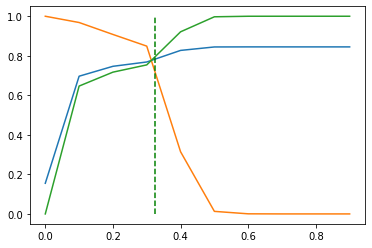

In [52]:
# Plot Accuracy, Recall and Spesificity at diff thresholds

cutoff_df_gan = calculate_labels_at_diff_thresholds(train_pred_df_gan)
plt.plot(cutoff_df_gan['prob'], cutoff_df_gan['accuracy'])
plt.plot(cutoff_df_gan['prob'], cutoff_df_gan['sensi'])
plt.plot(cutoff_df_gan['prob'], cutoff_df_gan['speci'])
plt.vlines(x=.325, ymax=1, ymin=0, colors='g', linestyles='--')

In [53]:
# Calculate labels at optimal threshold and recalculate metrics

train_pred_df_gan['final_predicted'] = train_pred_df_gan.Conv_Prob.map( lambda x: 1 if x > opt_threshold_gan else 0)
evaluate_model(train_pred_df_gan, pred='final_predicted')
train_pred_df_gan.head()

     thresholds       tpr       fpr      spec      diff
749    0.326872  0.784690  0.215883  0.784117  0.000573
750    0.325759  0.784690  0.215927  0.784073  0.000617
751    0.325660  0.784810  0.215927  0.784073  0.000738
748    0.326975  0.783363  0.215529  0.784471  0.001107
747    0.327075  0.783122  0.215529  0.784471  0.001348
Accuracy: 0.788, Recall: 0.766, Precision: 0.403, F1-score: 0.528, AUC: 0.856, Specificity: 0.792, G-Mean: 0.779, Optimal Threshold: 0.33


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.002602,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.001354,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.001354,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.345799,0,1,1,1,1,0,0,0,0,0,0,1
4,1,0.386057,0,1,1,1,1,0,0,0,0,0,0,1


In [54]:
# Evaluate model on test data

evaluate_model_on_test_data(train_pred_model_gan, lr_X_val_10, train_cols_gan, lr_y_val_10, opt_threshold_gan)

Accuracy: 0.804, Recall: 0.815, Precision: 0.446, F1-score: 0.577, AUC: 0.874, Specificity: 0.802, G-Mean: 0.808


In [55]:
# Save models

joblib.dump(train_pred_model, 'lr_10_base.pkl')
joblib.dump(train_pred_model_smote, 'lr_10_smote.pkl')
joblib.dump(train_pred_model_ada, 'lr_10_adasyn.pkl')
joblib.dump(train_pred_model_gan, 'lr_10_gan.pkl')

['lr_10_gan.pkl']

## 3. Random Forest
### 3.1 Base Data

In [56]:
# Function for random forest model

def run_random_forest(df_X, df_y, params_grid, scoring):
    best_score_rf = []
    best_estimator_rf = []
    sk_rf = model_selection.StratifiedKFold(n_splits=5)
    for train_ind_base, test_ind_base in sk_rf.split(df_X, df_y):
        X_train_cv, X_test_cv = df_X[train_ind_base], df_X[test_ind_base] 
        y_train_cv, y_test_cv = np.array(df_y)[train_ind_base], np.array(df_y)[test_ind_base]
        print(X_train_cv.shape, y_train_cv.shape, X_test_cv.shape, y_test_cv.shape)
        rf_base = ensemble.RandomForestClassifier(n_jobs=-1, random_state=42)

        gs_rf = model_selection.GridSearchCV(rf_base,
                                             param_grid=params_grid, 
                                             scoring=scoring, 
                                             n_jobs=-1,
                                             verbose=1,
                                             cv=sk_rf, 
                                             return_train_score=True)
        gs_rf.fit(X_train_cv, y_train_cv)
        print(gs_rf.best_score_)
        print(gs_rf.best_estimator_)
        gs_rf_best = gs_rf.best_estimator_
        train_proba_vals = gs_rf_best.predict_proba(X_train_cv)[:,1]
        train_auc = metrics.roc_auc_score(y_train_cv, train_proba_vals)
        test_proba_vals = gs_rf_best.predict_proba(X_test_cv)[:,1]
        test_auc = metrics.roc_auc_score(y_test_cv, test_proba_vals)
        print(f"AUC score on train data is {train_auc}")
        print(f"AUC score on test data is {test_auc}")
        best_score_rf.append(test_auc)
        best_estimator_rf.append(gs_rf_best)
    rf_best = best_estimator_rf[best_score_rf.index(max(best_score_rf))]
    print(rf_best)
    return rf_best

def pca_train_test_data(train_data, test_data, percent_val, compnents_val):
    pca_base = PCA(random_state=42)
    pca_base.fit(train_data)
    var_cumu = np.cumsum(pca_base.explained_variance_ratio_)
    plt.figure(figsize=[12,8])
    plt.hlines(y=percent_val, xmax=40, xmin=0, colors='g', linestyles='--')
    plt.vlines(x=compnents_val, ymax=1, ymin=0, colors='g', linestyles='--')
    plt.plot(var_cumu)
    plt.ylabel('Cumulative Variance Explained')
    pca_final_base = PCA(n_components=compnents_val, random_state=42)
    train_scaled_X_pca_base = pca_final_base.fit_transform(train_data)
    test_scaled_X_pca_base = pca_final_base.transform(test_data)
    print(train_scaled_X_pca_base.shape, test_scaled_X_pca_base.shape)
    return train_scaled_X_pca_base, test_scaled_X_pca_base

(26750, 15) (11465, 15)


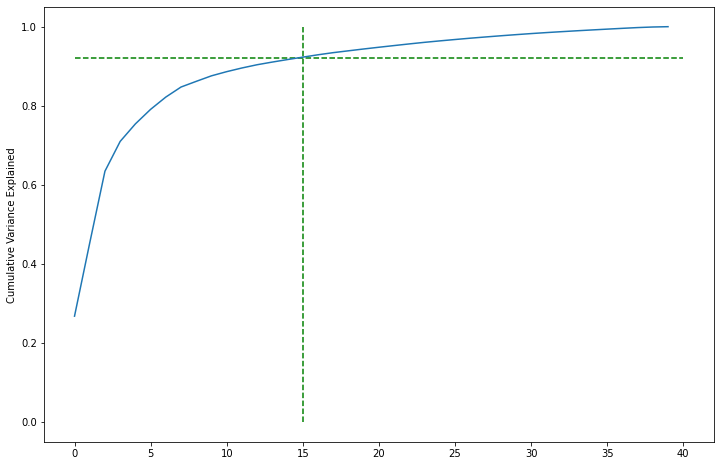

In [57]:
# Transform data

train_scaled_X_pca_base, test_scaled_X_pca_base = pca_train_test_data(lr_X_train_10, lr_X_val_10, .92, 15)

In [58]:
%%time

# Fit random Forest model with hyperparameters.

params_rf_base = {
    'n_estimators' : [20],
    'max_depth' : [16],
    'min_samples_leaf' : [16],
    'max_leaf_nodes' : [45]
}

gs_rf_base = run_random_forest(train_scaled_X_pca_base, lr_y_train_10, params_rf_base, 'roc_auc')

(21400, 15) (21400,) (5350, 15) (5350,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8830921598147334
RandomForestClassifier(max_depth=16, max_leaf_nodes=45, min_samples_leaf=16,
                       n_estimators=20, n_jobs=-1, random_state=42)
AUC score on train data is 0.9022776487333566
AUC score on test data is 0.8809603635821786
(21400, 15) (21400,) (5350, 15) (5350,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8813878887479125
RandomForestClassifier(max_depth=16, max_leaf_nodes=45, min_samples_leaf=16,
                       n_estimators=20, n_jobs=-1, random_state=42)
AUC score on train data is 0.9026025878707284
AUC score on test data is 0.8889216334662168
(21400, 15) (21400,) (5350, 15) (5350,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.881596945294086
RandomForestClassifier(max_depth=16, max_leaf_nodes=45, min_samples_leaf=16,
                       n_estimators=20, n_jobs=-1, random_state=42)
AUC score on train data is 0.9

In [59]:
# Calculate labels using arbitrary threshold value

gs_rf_base.fit(train_scaled_X_pca_base, lr_y_train_10)
rf_train_pred_df_base,_,_ = calculate_accuracy(gs_rf_base, '', train_scaled_X_pca_base, lr_y_train_10, predict_proba=True)
rf_train_pred_df_base

,Converted,Conv_Prob,Predicted
0,0,0.043527,0
1,0,0.006647,0
2,0,0.003815,0
3,0,0.452346,0
4,1,0.369963,0
...,...,...,...
26745,0,0.035137,0
26746,0,0.088627,0
26747,0,0.059617,0
26748,0,0.003815,0


In [60]:
# find optimal threshold value

_, _, _, opt_threshold_rf_base = evaluate_model(rf_train_pred_df_base, pred='Predicted')

      thresholds       tpr       fpr      spec      diff
3474    0.305813  0.822227  0.177799  0.822201  0.000026
3475    0.305476  0.822227  0.177933  0.822067  0.000160
3473    0.305838  0.821999  0.177754  0.822246  0.000247
3472    0.305839  0.821999  0.177709  0.822291  0.000292
3471    0.305843  0.821999  0.177620  0.822380  0.000381
Accuracy: 0.851, Recall: 0.216, Precision: 0.632, F1-score: 0.322, AUC: 0.901, Specificity: 0.975, G-Mean: 0.459, Optimal Threshold: 0.31


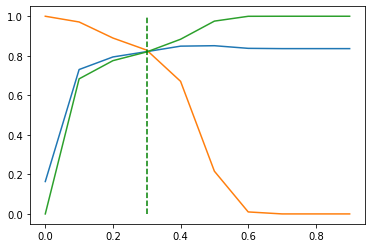

In [61]:
# Validate optimal threshold value

cutoff_df_rf_base = calculate_labels_at_diff_thresholds(rf_train_pred_df_base)
plt.plot(cutoff_df_rf_base['prob'], cutoff_df_rf_base['accuracy'])
plt.plot(cutoff_df_rf_base['prob'], cutoff_df_rf_base['sensi'])
plt.plot(cutoff_df_rf_base['prob'], cutoff_df_rf_base['speci'])
plt.vlines(x=.3, ymax=1, ymin=0, colors='g', linestyles='--')

In [62]:
# Reevaluate model with optimal threshold value

rf_train_pred_df_base['final_predicted'] = rf_train_pred_df_base.Conv_Prob.map( lambda x: 1 if x > opt_threshold_rf_base else 0)
evaluate_model(rf_train_pred_df_base, pred='final_predicted')
rf_train_pred_df_base.head()

      thresholds       tpr       fpr      spec      diff
3474    0.305813  0.822227  0.177799  0.822201  0.000026
3475    0.305476  0.822227  0.177933  0.822067  0.000160
3473    0.305838  0.821999  0.177754  0.822246  0.000247
3472    0.305839  0.821999  0.177709  0.822291  0.000292
3471    0.305843  0.821999  0.177620  0.822380  0.000381
Accuracy: 0.824, Recall: 0.82, Precision: 0.478, F1-score: 0.604, AUC: 0.901, Specificity: 0.825, G-Mean: 0.822, Optimal Threshold: 0.31


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.043527,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.006647,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.003815,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.452346,0,1,1,1,1,1,0,0,0,0,0,1
4,1,0.369963,0,1,1,1,1,0,0,0,0,0,0,1


In [63]:
# validate model on unseen data

evaluate_model_on_test_data(gs_rf_base, test_scaled_X_pca_base, '', lr_y_val_10, opt_threshold_rf_base, predict_proba=True)

Accuracy: 0.818, Recall: 0.827, Precision: 0.469, F1-score: 0.599, AUC: 0.889, Specificity: 0.817, G-Mean: 0.822


In [64]:
# Save models

joblib.dump(gs_rf_base, 'rf_10_base.pkl')

['rf_10_base.pkl']

### 3.2 SMOTE Data

(53500, 15) (11465, 15)


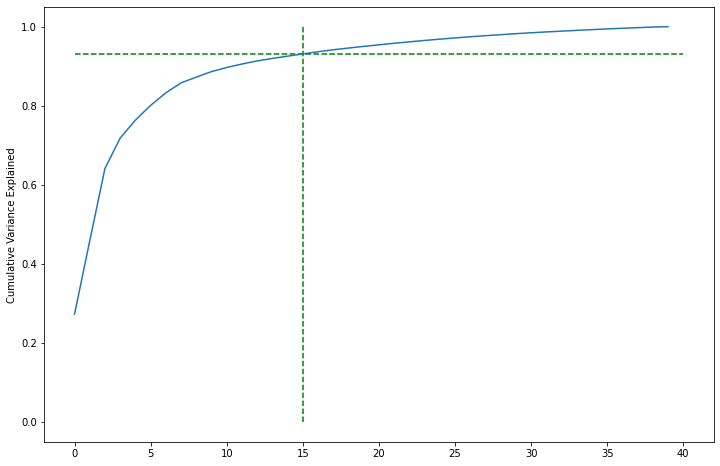

In [65]:
# Transform data

train_scaled_X_pca_smote, test_scaled_X_pca_smote = pca_train_test_data(X_train_low_10_smote, lr_X_val_10, 0.93, 15)

In [66]:
%%time

# Fit random Forest model with hyperparameters.

params_rf_smote = {
    'n_estimators' : [25],
    'max_depth' : [15],
    'min_samples_leaf' : [35],
    'max_leaf_nodes' : [60]
}

gs_rf_smote = run_random_forest(train_scaled_X_pca_smote, y_train_low_10_smote, params_rf_smote, 'roc_auc')

(42800, 15) (42800,) (10700, 15) (10700,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8962943050630079
RandomForestClassifier(max_depth=15, max_leaf_nodes=60, min_samples_leaf=35,
                       n_estimators=25, n_jobs=-1, random_state=42)
AUC score on train data is 0.9088152088316754
AUC score on test data is 0.8934572570998749
(42800, 15) (42800,) (10700, 15) (10700,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8968195897309175
RandomForestClassifier(max_depth=15, max_leaf_nodes=60, min_samples_leaf=35,
                       n_estimators=25, n_jobs=-1, random_state=42)
AUC score on train data is 0.9097955999170546
AUC score on test data is 0.89236908916175
(42800, 15) (42800,) (10700, 15) (10700,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8962790887554604
RandomForestClassifier(max_depth=15, max_leaf_nodes=60, min_samples_leaf=35,
                       n_estimators=25, n_jobs=-1, random_state=42)
AUC score on train data i

In [67]:
# Calculate labels using arbitrary threshold value

gs_rf_smote.fit(train_scaled_X_pca_smote, y_train_low_10_smote)
rf_train_pred_df_smote, _, _ = calculate_accuracy(gs_rf_smote, '', train_scaled_X_pca_smote, y_train_low_10_smote, predict_proba=True)
rf_train_pred_df_smote

,Converted,Conv_Prob,Predicted
0,0,0.039222,0
1,0,0.005471,0
2,0,0.005601,0
3,0,0.494963,0
4,1,0.362916,0
...,...,...,...
53495,1,0.125702,0
53496,1,0.401385,0
53497,1,0.485485,0
53498,1,0.448622,0


In [68]:
# find optimal threshold value

_, _, _, opt_threshold_rf_smote = evaluate_model(rf_train_pred_df_smote, pred='Predicted')

      thresholds       tpr       fpr      spec      diff
7271    0.304906  0.826335  0.173619  0.826381  0.000046
7270    0.304954  0.826335  0.173552  0.826448  0.000113
7272    0.304766  0.826563  0.173619  0.826381  0.000182
7273    0.304741  0.826563  0.173641  0.826359  0.000204
7269    0.304970  0.826221  0.173552  0.826448  0.000228
Accuracy: 0.858, Recall: 0.268, Precision: 0.667, F1-score: 0.382, AUC: 0.906, Specificity: 0.974, G-Mean: 0.511, Optimal Threshold: 0.3


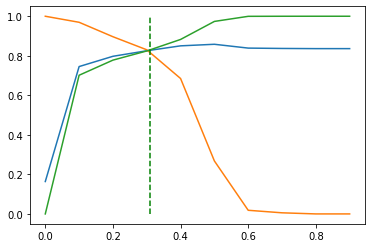

In [69]:
# Validate optimal threshold value

cutoff_df_rf_smote = calculate_labels_at_diff_thresholds(rf_train_pred_df_smote)
plt.plot(cutoff_df_rf_smote['prob'], cutoff_df_rf_smote['accuracy'])
plt.plot(cutoff_df_rf_smote['prob'], cutoff_df_rf_smote['sensi'])
plt.plot(cutoff_df_rf_smote['prob'], cutoff_df_rf_smote['speci'])
plt.vlines(x=.31, ymax=1, ymin=0, colors='g', linestyles='--')

In [70]:
# Reevaluate model with optimal threshold value

rf_train_pred_df_smote['final_predicted'] = rf_train_pred_df_smote.Conv_Prob.map( lambda x: 1 if x > opt_threshold_rf_smote else 0)
evaluate_model(rf_train_pred_df_smote, pred='final_predicted')
rf_train_pred_df_smote.head()

      thresholds       tpr       fpr      spec      diff
7271    0.304906  0.826335  0.173619  0.826381  0.000046
7270    0.304954  0.826335  0.173552  0.826448  0.000113
7272    0.304766  0.826563  0.173619  0.826381  0.000182
7273    0.304741  0.826563  0.173641  0.826359  0.000204
7269    0.304970  0.826221  0.173552  0.826448  0.000228
Accuracy: 0.825, Recall: 0.83, Precision: 0.481, F1-score: 0.609, AUC: 0.906, Specificity: 0.824, G-Mean: 0.827, Optimal Threshold: 0.3


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.039222,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.005471,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.005601,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.494963,0,1,1,1,1,1,0,0,0,0,0,1
4,1,0.362916,0,1,1,1,1,0,0,0,0,0,0,1


In [71]:
# validate model on unseen data

evaluate_model_on_test_data(gs_rf_smote, test_scaled_X_pca_smote, '', lr_y_val_10, opt_threshold_rf_smote, predict_proba=True)

Accuracy: 0.821, Recall: 0.814, Precision: 0.472, F1-score: 0.598, AUC: 0.889, Specificity: 0.822, G-Mean: 0.818


In [72]:
# Save models

joblib.dump(gs_rf_smote, 'rf_10_smote.pkl')

['rf_10_smote.pkl']

## 3.3 ADASYN Data

(53694, 15) (11465, 15)


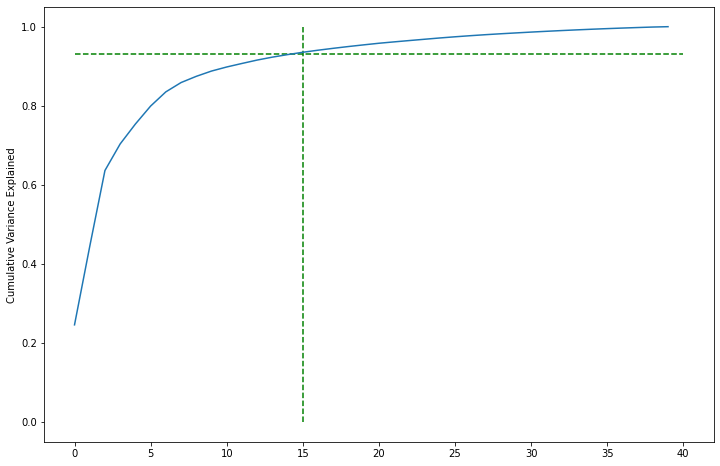

In [73]:
# Transform data

train_scaled_X_pca_ada, test_scaled_X_pca_ada = pca_train_test_data(X_train_low_10_adasyn, lr_X_val_10, 0.93, 15)

In [74]:
%%time

# Fit random Forest model with hyperparameters.

params_rf_ada = {
    'n_estimators' : [45],
    'max_depth' : [20],
    'min_samples_leaf' : [10],
    'max_leaf_nodes' : [70]
}

gs_rf_ada = run_random_forest(train_scaled_X_pca_ada, y_train_low_10_adasyn, params_rf_ada, 'roc_auc')

(42955, 15) (42955,) (10739, 15) (10739,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.7085245393386168
RandomForestClassifier(max_depth=20, max_leaf_nodes=70, min_samples_leaf=10,
                       n_estimators=45, n_jobs=-1, random_state=42)
AUC score on train data is 0.7857625591484725
AUC score on test data is 0.8950934358180652
(42955, 15) (42955,) (10739, 15) (10739,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.7053402299001983
RandomForestClassifier(max_depth=20, max_leaf_nodes=70, min_samples_leaf=10,
                       n_estimators=45, n_jobs=-1, random_state=42)
AUC score on train data is 0.7836352576980095
AUC score on test data is 0.8933068151398459
(42955, 15) (42955,) (10739, 15) (10739,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.7418524485781414
RandomForestClassifier(max_depth=20, max_leaf_nodes=70, min_samples_leaf=10,
                       n_estimators=45, n_jobs=-1, random_state=42)
AUC score on train data

In [75]:
# Calculate labels using arbitrary threshold value

gs_rf_ada.fit(train_scaled_X_pca_ada, y_train_low_10_adasyn)
rf_train_pred_df_ada, _, _ = calculate_accuracy(gs_rf_ada, '', train_scaled_X_pca_ada, y_train_low_10_adasyn, predict_proba=True)
rf_train_pred_df_ada

,Converted,Conv_Prob,Predicted
0,0,0.055114,0
1,0,0.033055,0
2,0,0.009295,0
3,0,0.263748,0
4,1,0.222288,0
...,...,...,...
53689,1,0.323381,0
53690,1,0.319004,0
53691,1,0.240693,0
53692,1,0.241365,0


In [76]:
# find optimal threshold value

_, _, _, opt_threshold_rf_ada = evaluate_model(rf_train_pred_df_ada, pred='Predicted')

      thresholds       tpr       fpr      spec      diff
8688    0.222055  0.700519  0.299474  0.700526  0.000007
8689    0.222055  0.700635  0.299474  0.700526  0.000108
8687    0.222104  0.700519  0.299340  0.700660  0.000140
8690    0.222030  0.700635  0.299563  0.700437  0.000197
8691    0.222029  0.700635  0.299629  0.700371  0.000264
Accuracy: 0.839, Recall: 0.003, Precision: 1.0, F1-score: 0.006, AUC: 0.795, Specificity: 1.0, G-Mean: 0.055, Optimal Threshold: 0.22


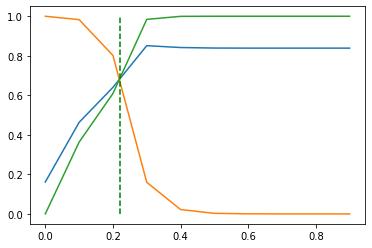

In [77]:
# Validate optimal threshold value

cutoff_df_rf_ada = calculate_labels_at_diff_thresholds(rf_train_pred_df_ada)
plt.plot(cutoff_df_rf_ada['prob'], cutoff_df_rf_ada['accuracy'])
plt.plot(cutoff_df_rf_ada['prob'], cutoff_df_rf_ada['sensi'])
plt.plot(cutoff_df_rf_ada['prob'], cutoff_df_rf_ada['speci'])
plt.vlines(x=.22, ymax=1, ymin=0, colors='g', linestyles='--')

In [78]:
# Reevaluate model with optimal threshold value

rf_train_pred_df_ada['final_predicted'] = rf_train_pred_df_ada.Conv_Prob.map( lambda x: 1 if x > opt_threshold_rf_ada else 0)
evaluate_model(rf_train_pred_df_ada, pred='final_predicted')
rf_train_pred_df_ada.head()

      thresholds       tpr       fpr      spec      diff
8688    0.222055  0.700519  0.299474  0.700526  0.000007
8689    0.222055  0.700635  0.299474  0.700526  0.000108
8687    0.222104  0.700519  0.299340  0.700660  0.000140
8690    0.222030  0.700635  0.299563  0.700437  0.000197
8691    0.222029  0.700635  0.299629  0.700371  0.000264
Accuracy: 0.695, Recall: 0.716, Precision: 0.309, F1-score: 0.431, AUC: 0.795, Specificity: 0.692, G-Mean: 0.704, Optimal Threshold: 0.22


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.055114,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.033055,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.009295,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.263748,0,1,1,1,0,0,0,0,0,0,0,1
4,1,0.222288,0,1,1,1,0,0,0,0,0,0,0,1


In [79]:
# validate model on unseen data

evaluate_model_on_test_data(gs_rf_ada, test_scaled_X_pca_ada, '', lr_y_val_10, opt_threshold_rf_ada, predict_proba=True)

Accuracy: 0.83, Recall: 0.678, Precision: 0.486, F1-score: 0.566, AUC: 0.885, Specificity: 0.86, G-Mean: 0.764


In [80]:
# Save models

joblib.dump(gs_rf_ada, 'rf_10_adasyn.pkl')

['rf_10_adasyn.pkl']

## 3.4 GAN Data

(53500, 17) (11465, 17)


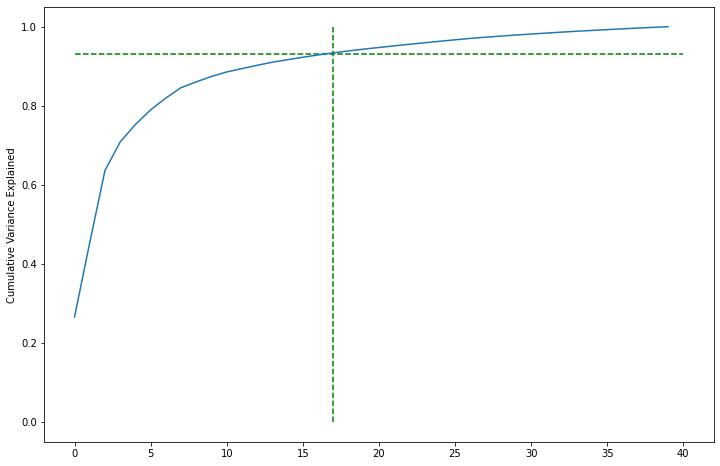

In [81]:
# Transform data

train_scaled_X_pca_gan, test_scaled_X_pca_gan = pca_train_test_data(X_train_low_10_gan, lr_X_val_10, 0.93, 17)

In [102]:
%%time

# Fit random Forest model with hyperparameters.

params_rf_gan = {
    'n_estimators' : [45],
    'max_depth' : [20],
    'min_samples_leaf' : [10],
    'max_leaf_nodes' : [70]
}

gs_rf_gan = run_random_forest(train_scaled_X_pca_gan, y_train_low_10_gan, params_rf_gan, 'roc_auc')

(42800, 17) (42800,) (10700, 17) (10700,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8524595297941661
RandomForestClassifier(max_depth=20, max_leaf_nodes=70, min_samples_leaf=10,
                       n_estimators=45, n_jobs=-1, random_state=42)
AUC score on train data is 0.879063251153292
AUC score on test data is 0.8808794761844092
(42800, 17) (42800,) (10700, 17) (10700,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8526643556306027
RandomForestClassifier(max_depth=20, max_leaf_nodes=70, min_samples_leaf=10,
                       n_estimators=45, n_jobs=-1, random_state=42)
AUC score on train data is 0.8799406502018565
AUC score on test data is 0.8807090317040067
(42800, 17) (42800,) (10700, 17) (10700,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8579853817445618
RandomForestClassifier(max_depth=20, max_leaf_nodes=70, min_samples_leaf=10,
                       n_estimators=45, n_jobs=-1, random_state=42)
AUC score on train data 

In [103]:
# Calculate labels using arbitrary threshold value

gs_rf_gan.fit(train_scaled_X_pca_gan, y_train_low_10_gan)
rf_train_pred_df_gan, _, _ = calculate_accuracy(gs_rf_gan, '', train_scaled_X_pca_gan, y_train_low_10_gan, predict_proba=True)
rf_train_pred_df_gan

,Converted,Conv_Prob,Predicted
0,0,0.055743,0
1,0,0.007188,0
2,0,0.006184,0
3,0,0.428747,0
4,1,0.346422,0
...,...,...,...
53495,0,0.007545,0
53496,0,0.013454,0
53497,0,0.131750,0
53498,0,0.010511,0


In [104]:
# find optimal threshold value

_, _, _, opt_threshold_rf_gan = evaluate_model(rf_train_pred_df_gan, pred='Predicted')

      thresholds       tpr       fpr      spec      diff
7661    0.294370  0.796866  0.203075  0.796925  0.000060
7662    0.294353  0.796986  0.203075  0.796925  0.000061
7660    0.294551  0.796866  0.202920  0.797080  0.000214
7663    0.293921  0.796986  0.203252  0.796748  0.000238
7659    0.294603  0.796745  0.202920  0.797080  0.000335
Accuracy: 0.848, Recall: 0.039, Precision: 0.697, F1-score: 0.073, AUC: 0.881, Specificity: 0.997, G-Mean: 0.197, Optimal Threshold: 0.29


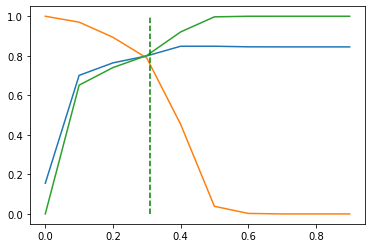

In [105]:
# Validate optimal threshold value

cutoff_df_rf_gan = calculate_labels_at_diff_thresholds(rf_train_pred_df_gan)
plt.plot(cutoff_df_rf_gan['prob'], cutoff_df_rf_gan['accuracy'])
plt.plot(cutoff_df_rf_gan['prob'], cutoff_df_rf_gan['sensi'])
plt.plot(cutoff_df_rf_gan['prob'], cutoff_df_rf_gan['speci'])
plt.vlines(x=.31, ymax=1, ymin=0, colors='g', linestyles='--')

In [106]:
# Reevaluate model with optimal threshold value

rf_train_pred_df_gan['final_predicted'] = rf_train_pred_df_gan.Conv_Prob.map( lambda x: 1 if x > opt_threshold_rf_gan else 0)
evaluate_model(rf_train_pred_df_gan, pred='final_predicted')
rf_train_pred_df_gan.head()

      thresholds       tpr       fpr      spec      diff
7661    0.294370  0.796866  0.203075  0.796925  0.000060
7662    0.294353  0.796986  0.203075  0.796925  0.000061
7660    0.294551  0.796866  0.202920  0.797080  0.000214
7663    0.293921  0.796986  0.203252  0.796748  0.000238
7659    0.294603  0.796745  0.202920  0.797080  0.000335
Accuracy: 0.796, Recall: 0.802, Precision: 0.417, F1-score: 0.549, AUC: 0.881, Specificity: 0.794, G-Mean: 0.798, Optimal Threshold: 0.29


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.055743,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.007188,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.006184,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.428747,0,1,1,1,1,1,0,0,0,0,0,1
4,1,0.346422,0,1,1,1,1,0,0,0,0,0,0,1


In [107]:
# validate model on unseen data

evaluate_model_on_test_data(gs_rf_gan, test_scaled_X_pca_gan, '', lr_y_val_10, opt_threshold_rf_gan, predict_proba=True)

Accuracy: 0.808, Recall: 0.857, Precision: 0.455, F1-score: 0.594, AUC: 0.888, Specificity: 0.799, G-Mean: 0.827


In [88]:
# Save models

joblib.dump(gs_rf_gan, 'rf_10_gan.pkl')

['rf_10_gan.pkl']